In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#

#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200724.pkl'

In [3]:
# load_pickle=True
# pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
# #
# if load_pickle:
#     with open(pkl_name, 'rb') as fin:
#         sacct_mazama=pickle.load(fin)
#     #
# else:
#     sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name)
#     #
    
#     with open(pkl_name, 'wb') as fout:
#             #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
#             out_pkl = pickle.dump(sacct_mazama, fout)

In [4]:
# n_cpus:
n_cpus = 1
if 'SLURM_JOB_ID' in os.environ.keys():
    # running in SLURM...
    if 'SLURM_JOB_CPUS_PER_NODE' in os.environ.keys():
        n_cpus = max( int(os.environ['SLURM_JOB_CPUS_PER_NODE']), 1)
    else:
        n_cpus = 1
else:
    n_cpus = min(8, mpp.cpu_count())
#
# or specify here:
# n_cpus = 8
#
print('** n_cpus: ', n_cpus)

** n_cpus:  4


In [5]:
end_dtm = dtm.datetime.now()+dtm.timedelta(days=1)
end_dtm = dtm.datetime(2022,1,21)
sacct_h5_file = f'sacct_data/serc_sacct_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
#start_date = '2021-04-15'
#end_date   = '2021-05-15'
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=180)
print('*** dates: {} - {}'.format(start_date, end_date))
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating new SACCT object from fresh data')
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    print(f'** {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
else:
    print('*** Fetching SACCT data from HDF5: {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_direct(group=None, partition='serc', start_date=str(start_date),
                                          n_cpu=n_cpus,
                                          end_date=str(end_date), keep_raw_data=False)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** dates: 2021-07-25 - 2022-01-21
**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


In [6]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(SACCT_obj.jobs_summary[cl]))
                                                   for cl in ['Start', 'Submit'] ]))
print('** cols: ', SACCT_obj.jobs_summary.dtype.names)

*** max_submit: 2022-01-20 13:29:04+00:00, max_start: 2022-01-20 13:24:48+00:00
** cols:  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


In [7]:
# NOTE: add this to the __init__. would be nice to refactor the code a bit to better handle inheritance.
if not 'chunk_size' in SACCT_obj.__dict__.keys():
    print('*** assigning chunk_size: ', chunk_size)
    SACCT_obj.chunk_size=1000

In [8]:
#
cpu_usage = SACCT_obj.active_jobs_cpu()
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=None)

<ipython-input-9-2e573529bc8b>:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-9-2e573529bc8b>:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-9-2e573529bc8b>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(18800.0, 0, '2021-6-22'),
 Text(18825.0, 0, '2021-7-17'),
 Text(18850.0, 0, '2021-8-11'),
 Text(18875.0, 0, '2021-9-5'),
 Text(18900.0, 0, '2021-9-30'),
 Text(18925.0, 0, '2021-10-25'),
 Text(18950.0, 0, '2021-11-19'),
 Text(18975.0, 0, '2021-12-14'),
 Text(19000.0, 0, '2022-1-8'),
 Text(19025.0, 0, '2022-2-2')]

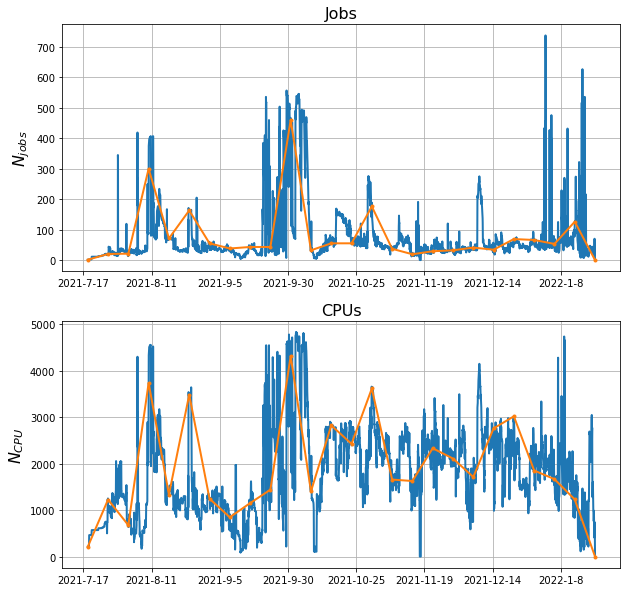

In [9]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [11]:
# def time_bin_aggregates(XY, bin_mod=24, qs=[.25, .5, .74]):
#     XY=numpy.array(XY)
#     if XY.shape[0]==2:
#         X = XY[0,:]
#         Y = XY[1:]
#     else:
#         X = XY[:,0]
#         Y = XY[:,1]
#     #
#     #X_mod = ((X*bin_mod)%bin_mod).astype(int)
#     X_mod = ((X%1.)*bin_mod).astype(int)
#     #
#     stats_output=[]
#     for x in numpy.unique(X_mod):
#         ix = X_mod==x
#         this_Y = Y[ix]
#         stats_output += [numpy.append([x, numpy.mean(this_Y), numpy.std(this_Y)],
#                                       numpy.quantile(this_Y, qs))]
#     #
#     return numpy.core.records.fromarrays(numpy.array(stats_output).T, dtype=[('x', '>f8'), ('mean', '>f8'),
#                                                         ('stdev', '>f8')] + 
#                                          [('q_{}'.format(q), '>f8') for q in qs])
# #

    

<ipython-input-10-70aae9fac9e3>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-10-70aae9fac9e3>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


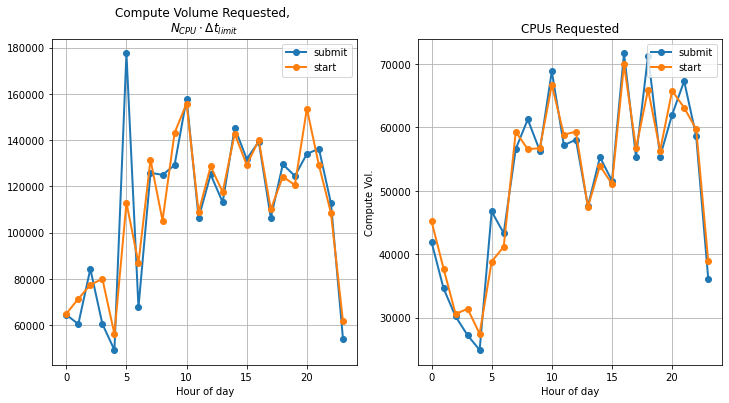

In [10]:
qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

Text(0.5, 0.98, 'Instantaneous Usage')

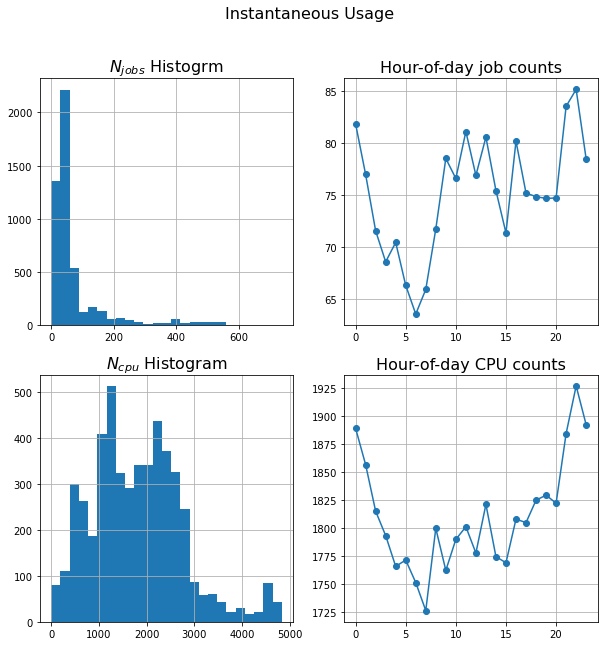

In [11]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
axs = [ax1, ax2, ax3, ax4]
[ax.grid() for ax in axs]
#
cpu_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_cpu']]).T)
jobs_hourly = hpc_lib.time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_jobs']]).T)

hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o')

hh3 = ax3.hist(cpu_usage['N_cpu'], bins=25)
ax4.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o')

#ax1.set_ylim(-5., 200)
ax1.set_title('$N_{jobs}$ Histogrm', size=16)
ax2.set_title('Hour-of-day job counts', size=16)
ax3.set_title('$N_{cpu}$ Histogram', size=16)
ax4.set_title('Hour-of-day CPU counts', size=16)
#
plt.suptitle('Instantaneous Usage', size=16)

In [12]:
weekly_hours = SACCT_obj.get_cpu_hours(bin_size=7, n_points=5000)

daily_hours = SACCT_obj.get_cpu_hours(bin_size=1, n_points=5000)

<ipython-input-13-2905a9f308a7>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lbls)


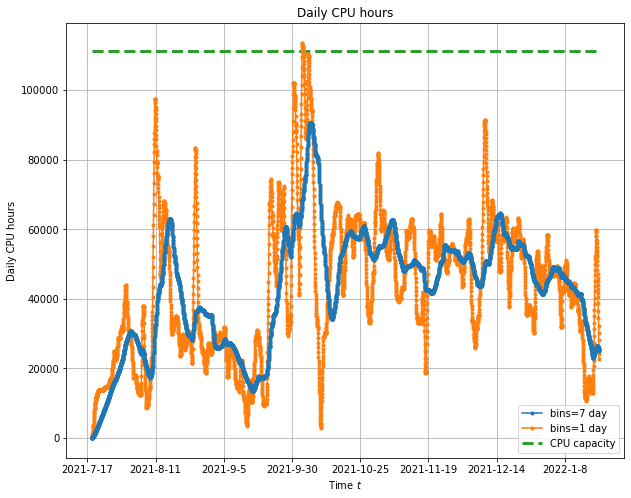

In [13]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)
#
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*14*24*24, ls='--', lw=3.)
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*12*24*24, ls='--', lw=3.)
#
n_cpus_serc = 32*104 + 128*8 + 24*12
n_cpus_serc_gpus = n_cpus_serc + 128*6 + 24*2
ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*24*n_cpus_serc, ls='--', lw=3.,
         label='CPU capacity')
#ax1.plot( daily_hours['time'][0::(len(daily_hours['time'])-1)], numpy.ones(2)*24*n_cpus_serc_gpus, ls='--', lw=3.)




#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

In [14]:
print('** dtype:\n', SACCT_obj.jobs_summary.dtype)
#
#user_cols  = ['Timelimit', 'NCPUS', 'NNodes', 'TotalCPU','NTasks']
#user_types = ['>f8', '>i8', '>i8', '>f8', '>i8', '>f8']

user_cols = ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
user_types = ['>i8', '>i8', '>f8', '>f8']
#
user_aggs = numpy.zeros( shape=[len(numpy.unique(SACCT_obj.jobs_summary['User'])),],
                        dtype={'names':user_cols, 'formats':user_types })
#
ix = {usr:numpy.where(SACCT_obj.jobs_summary['User']==usr)[0] 
      for usr in numpy.unique(SACCT_obj.jobs_summary['User'])}
#

** dtype:
 [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S86'), ('JobID', 'S20'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S50'), ('AllocTRES', 'S64'), ('JobID_parent', 'S20')]


In [15]:
print('*** ', user_aggs.shape, user_aggs.dtype)
print('*** ', user_cols)
user_names = numpy.unique(SACCT_obj.jobs_summary['User'])
for k,user in enumerate(user_names):
    #print('** ', [numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    #
    vals = [numpy.sum( numpy.max([numpy.zeros(len(ix[user])), SACCT_obj.jobs_summary[cl][ix[user]]], axis=0) ) 
                      for cl in user_cols[:-1]]
    vals += [numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix[user]]*24. * SACCT_obj.jobs_summary['NCPUS'][ix[user]])]
    #print('** ix: ', ix[user])
    #vals = [numpy.sum( (SACCT_obj.jobs_summary[cl][ numpy.array(ix[user])] ) )
    #        for cl in user_cols]
    #print('** vals: ', vals)
    
    #user_aggs[user_cols][k] = tuple([numpy.sum(SACCT_obj.jobs_summary[cl][ix[user]]) for cl in user_cols])
    
    user_aggs[user_cols][k] = tuple( vals )
    #user_aggs[user_cols][k] = tuple(vals)



***  (98,) [('NCPUS', '>i8'), ('NNodes', '>i8'), ('Elapsed', '>f8'), ('Comp_Vol', '>f8')]
***  ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']


In [16]:
print('** user, {}'.format(user_cols ) )
for nm,rw in zip(user_names, user_aggs):
    print('** {}: {}, '.format(nm,rw))

** user, ['NCPUS', 'NNodes', 'Elapsed', 'Comp_Vol']
** b'abroome': (11079, 319, 41.21770833, 47797.00194444), 
** b'acb18': (58, 18, 0.02465278, 0.82166667), 
** b'aguilars': (24184, 1643, 36.74457176, 3070.9725), 
** b'agunn': (64, 13, 0.00241898, 0.27222222), 
** b'aitous': (1656, 163, 267.04799769, 67281.96388889), 
** b'ammilten': (80, 10, 2.52233796, 484.28888889), 
** b'andchu': (1275, 52, 110.73800926, 80740.00083333), 
** b'andea98': (293, 25, 18.5750463, 6184.92), 
** b'aparada': (1468, 56, 33.27829861, 25936.29555556), 
** b'arandia': (352, 40, 13.26094907, 4132.55194444), 
** b'asarhadi': (373183, 46373, 5328.57556713, 1059941.65722222), 
** b'awan005': (346, 122, 0.82733796, 60.28277778), 
** b'axelwang': (7387, 689, 854.28697917, 475700.0275), 
** b'bdelorme': (3724, 614, 27.76565972, 38740.53222222), 
** b'bienert': (3, 3, 2.1612963, 51.87111111), 
** b'bobyang9': (288, 36, 0.11924769, 22.89555556), 
** b'cbaden': (2259, 173, 190.87832176, 38416.02388889), 
** b'cculha': 

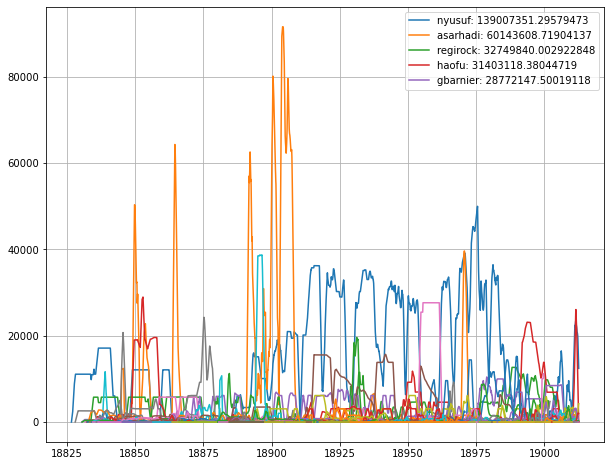

In [19]:
fg = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.grid()
for k,usr in enumerate(user_names[numpy.argsort(user_aggs['Comp_Vol'])[::-1]]):
    cpuh = SACCT_obj.get_cpu_hours(bin_size=1.0, jobs_summary=SACCT_obj.jobs_summary[ix[usr]])
    ax.plot(cpuh['time'], cpuh['cpu_hours'], label=('{}: {}'.format(usr, numpy.sum(cpuh['cpu_hours']) )
                                                    if k<5 else None) )
ax.legend(loc=0)

<ipython-input-20-ba0d35d16ea0>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('121')
<ipython-input-20-ba0d35d16ea0>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('122')


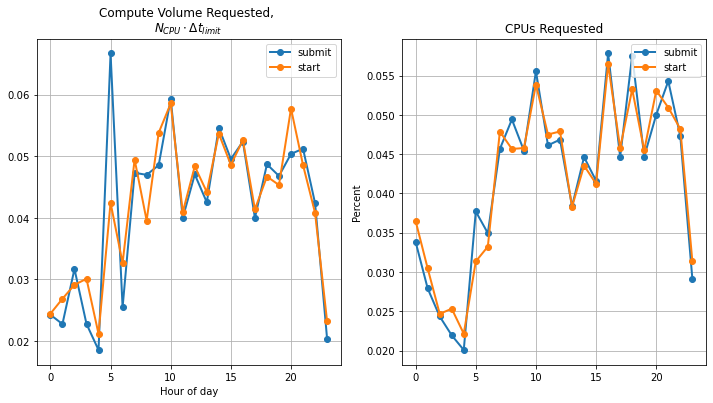

In [20]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = SACCT_obj.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = SACCT_obj.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time']),
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))

ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time']),
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/numpy.sum(comp_vol_start['cpu-time'])))
#
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/numpy.sum(comp_vol_submit['cpus']), ls='-', marker='o', lw=2., label='submit')
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/numpy.sum(comp_vol_start['cpus']), ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Percent')

ax2.set_title('CPUs Requested')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')


Text(0.5, 1.0, '(Cumulative)')

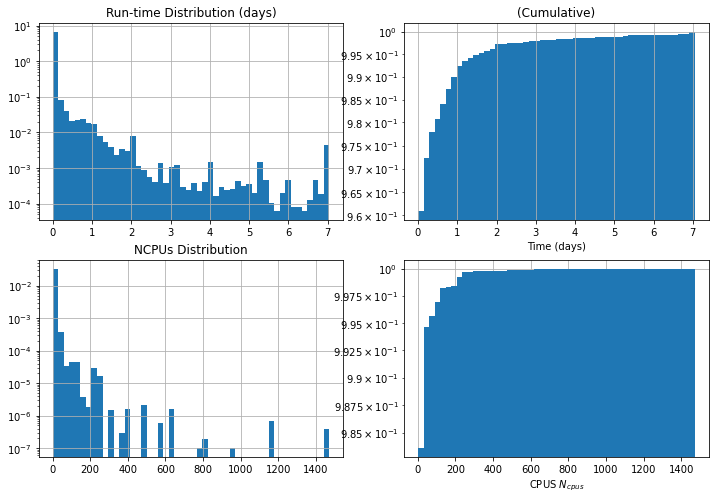

In [21]:
# compute some distributions:
print('*** ', SACCT_obj.jobs_summary.dtype.names)
run_times = SACCT_obj.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
#ax1a.set_yscale('log')
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, density=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, density=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True)
hh22 = ax4.hist(SACCT_obj.jobs_summary['NCPUS'], bins=50, density=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [22]:
print('** ', len(run_times), len(SACCT_obj.jobs_summary['NCPUS']))

**  347380 347390


In [23]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(SACCT_obj.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.996136795440152, 0.9995365306004952, 1.0
*** N_24/N=0.9834129771431861


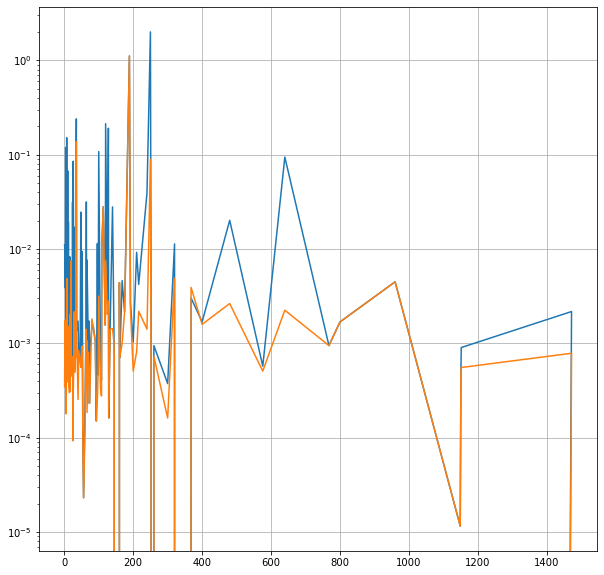

In [24]:
wait_stats = SACCT_obj.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')

***  ['2019-10-31', '2020-2-8', '2020-5-18', '2020-8-26', '2020-12-4', '2021-3-14', '2021-6-22', '2021-9-30', '2022-1-8', '2022-4-18']


<ipython-input-17-ff8e6c5bdb1b>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-17-ff8e6c5bdb1b>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)
<ipython-input-17-ff8e6c5bdb1b>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


Text(0.5, 0.98, 'Mazama Activity, $\\Delta t_{binsize}=7$ days')

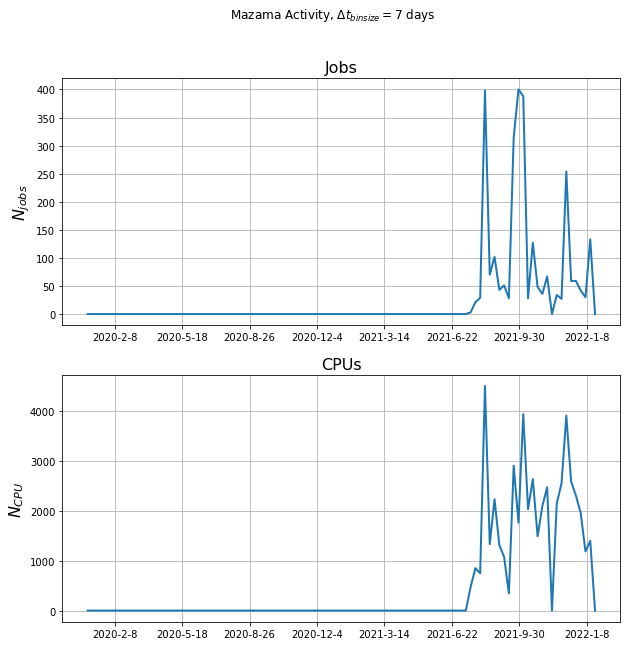

In [17]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


<ipython-input-26-794c851249f7>:30: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = fg.add_subplot('211')
<ipython-input-26-794c851249f7>:31: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = fg.add_subplot('212', sharex=ax1)


***  ['2019-10-31', '2020-2-8', '2020-5-18', '2020-8-26', '2020-12-4', '2021-3-14', '2021-6-22', '2021-9-30', '2022-1-8', '2022-4-18']


<ipython-input-26-794c851249f7>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(lbls)


[Text(18200.0, 0, '2019-10-31'),
 Text(18300.0, 0, '2020-2-8'),
 Text(18400.0, 0, '2020-5-18'),
 Text(18500.0, 0, '2020-8-26'),
 Text(18600.0, 0, '2020-12-4'),
 Text(18700.0, 0, '2021-3-14'),
 Text(18800.0, 0, '2021-6-22'),
 Text(18900.0, 0, '2021-9-30'),
 Text(19000.0, 0, '2022-1-8'),
 Text(19100.0, 0, '2022-4-18')]

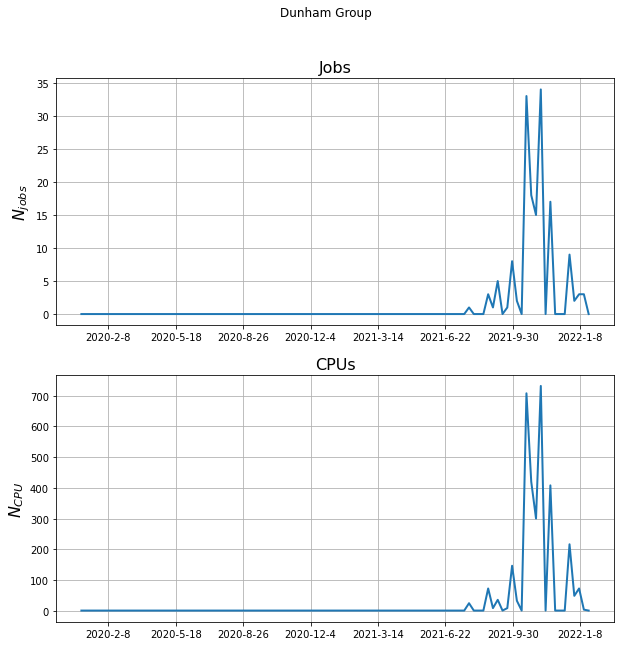

In [26]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in SACCT_obj.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
#
cpu_weekly = SACCT_obj.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text().replace(chr(8722), '-'))) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

In [27]:
# if True:
#     with open(data_file_name, 'r') as fin:
#         header_rw = fin.readline()
#         print('*** ', header_rw)

#     headers = header_rw.split('|')
#     k_group = headers.index('Group')
#     k_gid = headers.index('GID')
#     #
    
#     with open(data_file_name, 'r') as fin:
#         for k,rw in enumerate(fin):
#             #if 'dunham' in rw: print('** ', rw)
#             #if 'dunham' in rw:
#             #    rws = rw.split('|')
#             #    print('** ', rws[k_group], rws[k_gid])
#             if 'Partition_Limit' in rw:
#                 print('** ', rw)
#                 k+=1
#                 if k>10: break



In [28]:
print('** ',SACCT_obj.jobs_summary.dtype.names)
print('** ', mpd.num2date(SACCT_obj.jobs_summary['Submit'][-1]))

**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'JobID_parent')
**  2022-01-20 13:24:48+00:00


In [29]:
dta = SACCT_obj.jobs_summary.copy()
dta.sort(order='Submit')

## Drafts of some reports
- We have a couple reports already made. Let's start with those.
- Even for those reports, we'll want to modify the inputs, for example to specify all Earth users/groups, not juust look at the `serc` partition.


In [30]:
### Report(s)
#
# first, we need to make groups.
# groups who can access serc:
# (base) [myoder96@sh01-ln01 login ~]$ scontrol show partition serc | grep Allow
#   AllowGroups=sh_s-ees,sh_sysadm AllowAccounts=ALL AllowQos=normal,high_p,system
#
# so all permissions are consolidated to the sh_s-ees group
# to get users in a group:
# USERS=`getent passwd | awk -F: -v g=$(id -g $PI_SUNET) '$4==g {print $1}'`
#. but this does not seem to work for the sh_s-ees group
# we can use id to get secondary groups (we'll need to pares...), for example,
# $ (base) [myoder96@sh01-ln01 login ~/Codes/cees_scripts]$ id myoder96
# uid=362778(myoder96) gid=32264(ruthm) groups=99001(sh_users),98013(sh_sw-stata),98008(sh_sw-schrodinger),97002(sh_s-ees),97005(sh_s-hns),1007582(oak_p-cees-backup),1008811(oak_s-ees),32264(ruthm)
# this should do it:
# getent group sh_s-ees
# then maybe just parse in Python...

In [20]:
PI_groups = hpc_lib.get_PI_groups_from_groups(groups='sh_s-ees')
#
for ky,vl in PI_groups.items():
    print('** {}, {}'.format(ky,vl))
    #
#
SACCT = hpc_lib.SACCT_data_direct(partition='serc', start_date='2021-01-01', end_date='2021-06-03',
                                  keep_raw_data=False)
#
rpt = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC HPC Analytics', 
                Full_title='HPC Analytics Breakdown for Stanford Earth, Sherlock SERC',
                out_path='output/SERC_analytics_20210602', tex_filename='SERC_HPC_analytics.tex',
                                           groups=PI_groups, SACCT_obj=SACCT)


** dekas, ['klawonn', 'rsalcedo', 'yuranz4', 'yunha', 'aparada', 'semler', 'arandia', 'dekas', 'kapili', 'sbuessec', 'erparis', 'nrmeyer']
** mburke, ['ihigueme', 'samhn', 'mhzahid', 'jessssli', 'mburke', 'jlwen', 'djxgonz', 'marissac']
** lou, ['amyfzou', 'lou', 'rmorsini', 'ykim07', 'ovolkov', 'zhiweima', 'cooper96', 'hytang', 'sujiang', 'nyusuf', 'trye', 'yifu', 'filippk']
** smbenson, ['ebaik', 'fayoola', 'gegewen', 'jihan123', 'haycat', 'andchu', 'smbenson']
** tchelepi, ['hjyang3', 'jfranc', 'kassem', 'ishovkun', 'jiaweili', 'ytian96', 'luizebs', 'jaewooan', 'ju1', 'boelens', 'klevtsov', 'rasim', 'tchelepi']
** robertj2, ['sferon', 'efluet', 'ouyangzt', 'gmcnicol', 'leehi', 'agaspert', 'robertj2', 'chwang01', 'lydiav', 'saraknox', 'frankliu', 'sjg79']
** jkw1, ['sarakeen', 'jkw1']
** harrisgp, ['rumaih', 'harrisgp', 'lidongzh']
** aditis2, ['nseay', 'briangre', 'mborrus', 'acb18', 'aditis2', 'lauraman', 'cwilka', 'zespinos', 'ealindgr']
** oneillm, ['hsstern', 'htang12', 'yy2822'

### CEES Sherlock report(s)
- Let's just get into this... What we need:
- Standard(ish) report of SERC (and other) partition(s) usage
- Mostly same standard report for each active PI group

#### Standard report:
- jobs,cpus
- cpu-hours
- Time-of-Day, Day-of-week usage
- 

#### Basic workflow:
- Get full SACCT data for `serc` partition
- Run report on partition usage
- Get active groups (group name + users?)
- Fetch new SACCT_obj for each group
- Run report for each group.

keys:  dict_keys(['All'])
*** DEBUG: group: All


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1787: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1790: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1834: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [All] Slide_1 added??:: 3


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1216: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


*** Slide_2 added??::  4
** adding slide: slide_2
** adding slide: slide_3


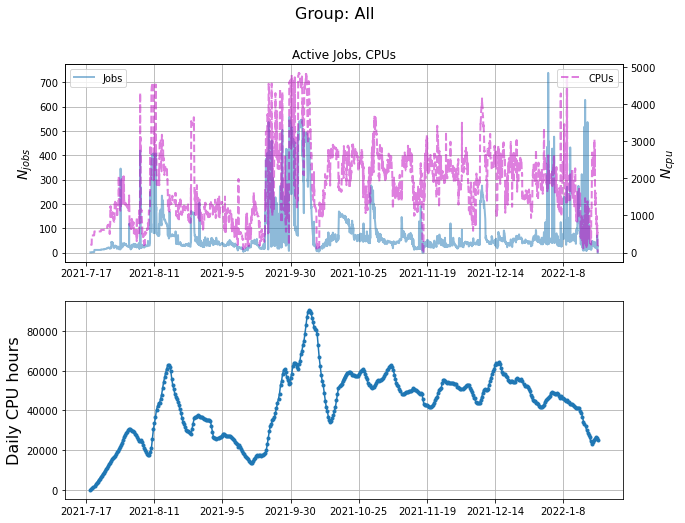

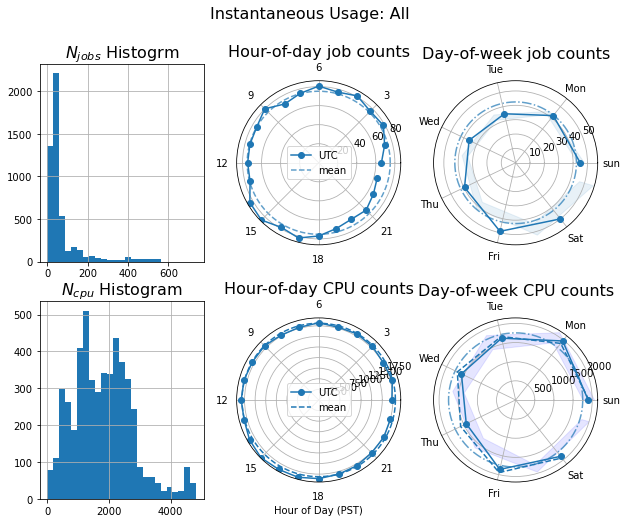

In [23]:
serc_report = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC Analytics', Full_title='SERC HPC analytics',
                                                  SACCT_obj=SACCT_obj,
                                                  out_path='output/SERC_analytics_20220121',
                                                   tex_filename='SERC_HPC_analytics.tex'
                                                  )



keys:  dict_keys(['All'])
*** DEBUG: group: All


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1787: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax1 = plt.subplot('211')
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1790: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax2 = plt.subplot('212', sharex=ax1)
/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1834: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


*** [All] Slide_1 added??:: 3


/home/users/myoder96/Codes/HPC_analytics/hpc_lib.py:1216: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


*** Slide_2 added??::  4
** adding slide: slide_2
** adding slide: slide_3


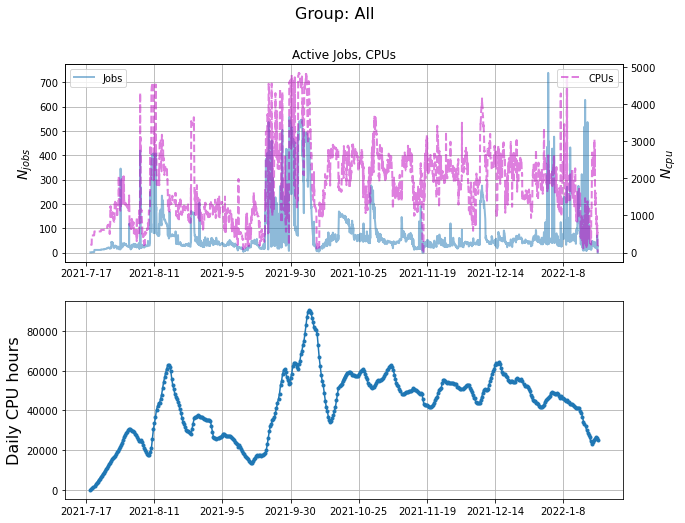

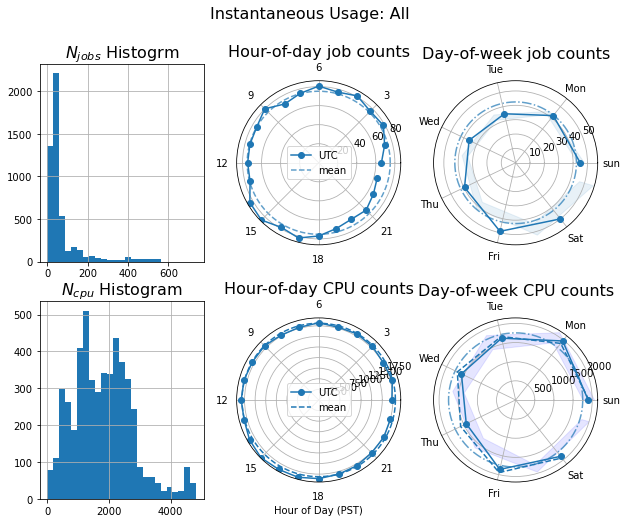

In [24]:

serc_report_h = hpc_lib.SACCT_groups_analyzer_report(Short_title='SERC Analytics', Full_title='SERC HPC analytics',
                                                  SACCT_obj=SACCT_obj,
                                                  out_path='output/SERC_analytics_20220121_h',
                                                   tex_filename='SERC_HPC_analytics.tex'
                                                  )